In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from scipy import signal
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Load data

In [2]:
data1 = sio.loadmat(r'./Salinas_corrected.mat')
data2 = sio.loadmat(r'./Salinas_gt.mat')
print(data1.keys())
print(data2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [3]:
salinas_img = data1['salinas_corrected']
salinas_labels = data2['salinas_gt']
print("Salinas shape: {}".format(salinas_img.shape))


Salinas shape: (512, 217, 204)


Text(0.5, 1.0, 'Salinas labels')

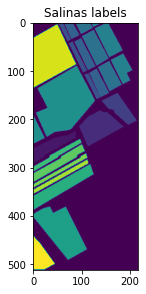

In [4]:
# Display ground truth for each image
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(salinas_labels, cmap='viridis')
plt.title('Salinas labels')

# Plot the curve of one sample

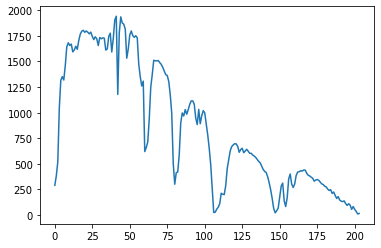

In [5]:
# get any position 
pos = [0,1]
feature = salinas_img[pos[0],pos[1],:]
plt.plot(feature)

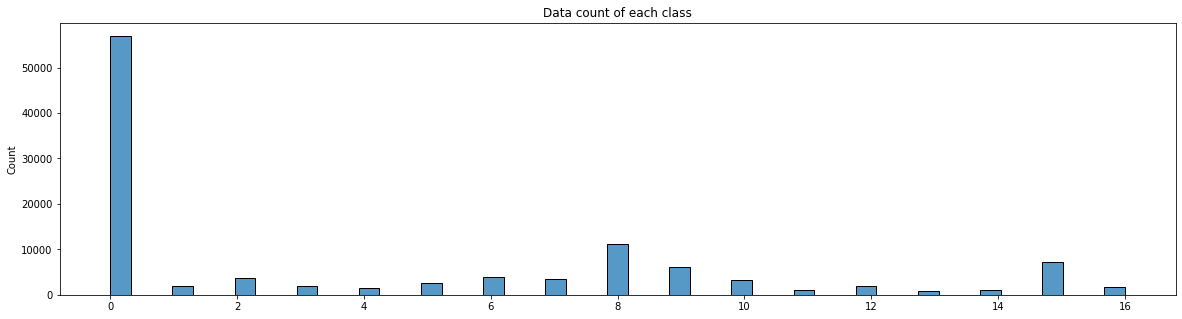

In [6]:
plt.figure(figsize=(20,5))
ax_salinas = sns.histplot(salinas_labels.flatten())
plt.title("Data count of each class")
plt.show()

# Reshape the data

In [7]:
X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
y_gt = salinas_labels.ravel()
print("Salinas shape: {}".format(X_salinas.shape))

Salinas shape: (111104, 204)


# PCA

In [8]:
#this function is from "tools.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
print("Fitting the PCA")
pca_model = PCA()
pca_model.fit(X_salinas)
var_cumsum = pca_model.explained_variance_ratio_.cumsum()
num_useful_feature = len(var_cumsum[var_cumsum <= 0.997])
print("Number of components Salinas:")
print(num_useful_feature) 

Fitting the PCA
Number of components Salinas:
4


The first graph shows the variance ratio of features(PCA) and the second graph is the cumulative sum of variance ratio

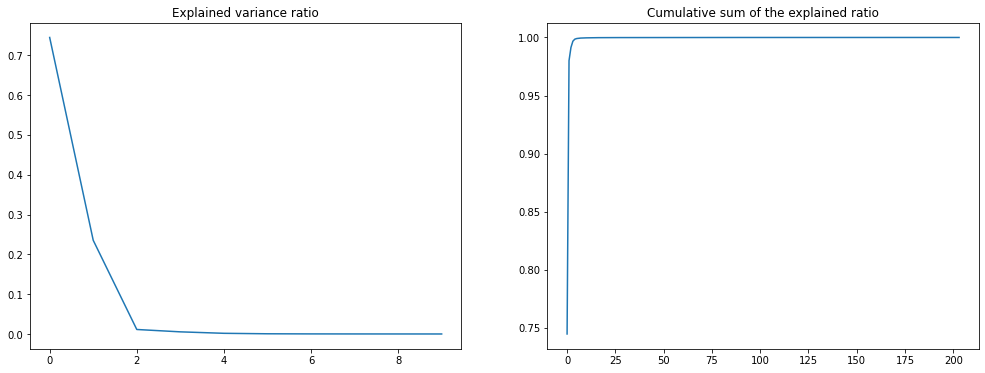

In [9]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
plt.figure(figsize=(17,6))
plt.subplot(1, 2, 1)
plt.plot(pca_model.explained_variance_ratio_[:10])
plt.title("Explained variance ratio")

plt.subplot(1, 2, 2)
plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

In [10]:
pca_model = PCA(n_components = num_useful_feature)
pca_model.fit(X_salinas)
X_salinas_reduced_pca = pca_model.transform(X_salinas)
print(X_salinas_reduced_pca.shape)

(111104, 4)


# Remove the background

In [11]:
X_salinas_reduced_pca = np.delete(X_salinas_reduced_pca, np.where(y_gt == 0), axis = 0)
y = np.delete(y_gt, np.where(y_gt == 0))

print(X_salinas_reduced_pca.shape)
print(y.shape)



(54129, 4)
(54129,)


# Rescale the data into range (0,1)

In [12]:
# setup the MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0, 1))
# Normalization: transform the dataset into the range [0,1]
X_salinas_01 = scaler.fit_transform(X_salinas_reduced_pca)

# Splite data into train and test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_salinas_01, y, test_size=0.25, random_state=42)

In [14]:
print("Train shape: {}".format(X_train.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test shape: {}".format(X_test.shape))
print("Test labels shape: {}".format(y_test.shape))

Train shape: (40596, 4)
Train labels shape: (40596,)
Test shape: (13533, 4)
Test labels shape: (13533,)


# Random Forest Classification

In [15]:
modelRF_salinas = RandomForestClassifier(n_estimators=100, n_jobs=8)

K-Fold validation

In [16]:
%%time
scores = cross_val_score(modelRF_salinas, X_train, y_train, cv=5)

Wall time: 10.1 s


In [17]:
print(scores)
print("The average score is {}".format(np.mean(scores)))

[0.92598522 0.92794679 0.92462126 0.92536027 0.92893213]
The average score is 0.9265691344938618


In [18]:
%%time
#Fit the model
modelRF_salinas.fit(X_train, y_train)

Wall time: 2.02 s


RandomForestClassifier(n_jobs=8)

Output the training score and testing score

In [19]:
%%time
modelRF_salinas.verbose=0
preds_salinas_test = modelRF_salinas.predict(X_test)
salinas_test_score = accuracy_score(y_test, preds_salinas_test)
print("Salinas training score is {} and testing score is {}".format(np.mean(scores), salinas_test_score))

Salinas training score is 0.9265691344938618 and testing score is 0.9295795462942437
Wall time: 109 ms


The comparison histogram of predicted labels and expected labels

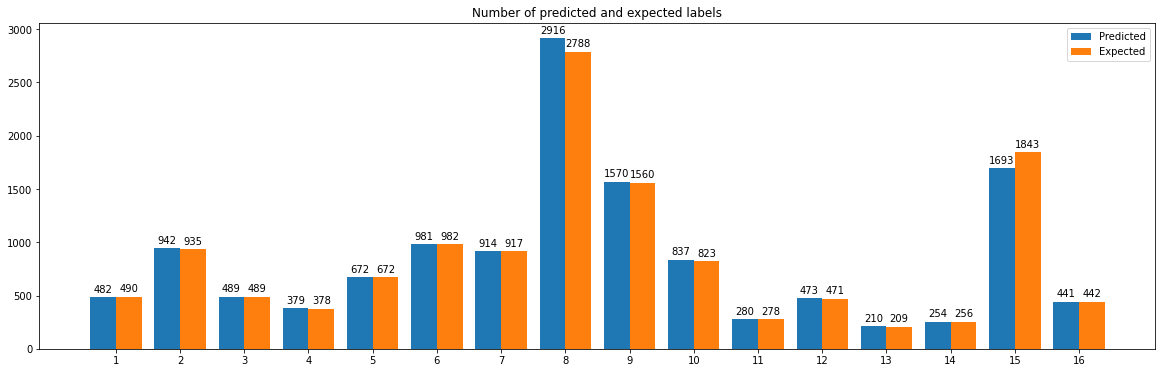

In [20]:
#this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
fig, axs = plt.subplots(figsize=(20, 6))

bar_x, bar_count_pred = np.unique(preds_salinas_test, return_counts=True)
bar1 = axs.bar(bar_x - 1.2, bar_count_pred, 0.4, label="Predicted")

bar_x, bar_count_exp = np.unique(y_test, return_counts=True)
bar2 = axs.bar(bar_x - 0.8, bar_count_exp, 0.4, label="Expected")

title='Number of predicted and expected labels'

axs.bar_label(bar1, padding=3)
axs.bar_label(bar2, padding=3)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title(title)
axs.legend()
plt.show()

Predict the total data

In [21]:
%%time
total_preds_salinas = modelRF_salinas.predict(X_salinas_01)

Wall time: 305 ms


Final performance of this model

In [22]:
#accuracy
total_preds_salinas_score = accuracy_score(y, total_preds_salinas)
print("The final accuracy of this model is {}".format(total_preds_salinas_score))

The final accuracy of this model is 0.9823754364573519


In [23]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y, total_preds_salinas))

0.7785660182157439


In [24]:
#precision,recall,f1-score
from sklearn.metrics import classification_report
print(classification_report(y, total_preds_salinas))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2009
           2       1.00      1.00      1.00      3726
           3       1.00      1.00      1.00      1976
           4       1.00      1.00      1.00      1394
           5       1.00      1.00      1.00      2678
           6       1.00      1.00      1.00      3959
           7       1.00      1.00      1.00      3579
           8       0.96      0.97      0.96     11271
           9       1.00      1.00      1.00      6203
          10       0.98      0.99      0.99      3278
          11       0.99      0.99      0.99      1068
          12       1.00      1.00      1.00      1927
          13       1.00      1.00      1.00       916
          14       1.00      1.00      1.00      1070
          15       0.95      0.93      0.94      7268
          16       1.00      1.00      1.00      1807

    accuracy                           0.98     54129
   macro avg       0.99   

# Result visualization

In [25]:
idx = np.argwhere(salinas_labels.flatten() != 0).flatten()

In [26]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_preds_img[idx] = total_preds_salinas
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

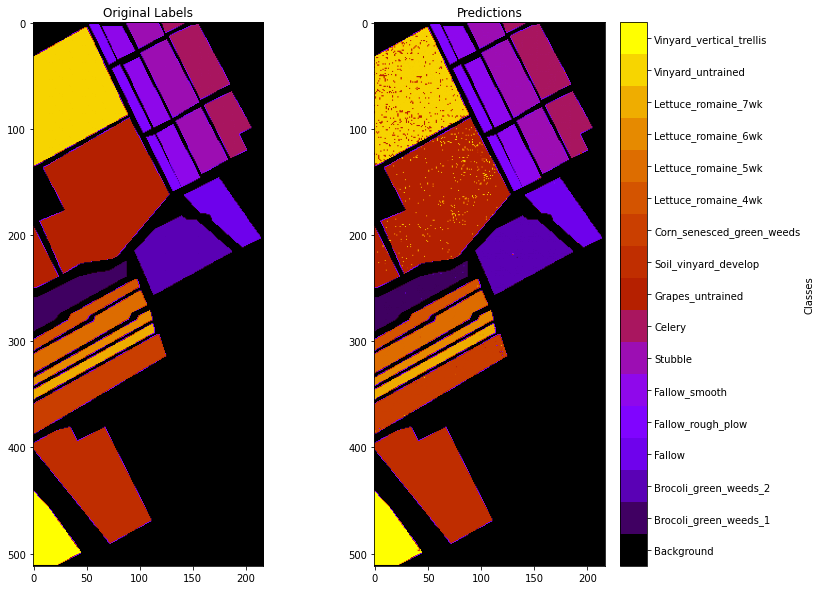

In [27]:
global GROUND_TRUTH
global NUM_CLASSES
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
plt.title('Original Labels')
plt.imshow(salinas_labels,cmap='gnuplot')

plt.subplot(1, 2, 2)
plt.title('Predictions')
plt.imshow(salinas_preds_img,cmap='gnuplot')

cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)
plt.show()